# PDF Text Retrieval and RAG Tutorial Pipeline

In [1]:
import fitz  # PyMuPDF
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer

/opt/home/frehm/tutorial_rag/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Preparation
### 1.1 Load PDF file and extract the text as string.

In [2]:
def retrieve_pdf_text(path):
    """Extracts text from all PDF pages."""
    try:
        doc = fitz.open(path)
        return "\n".join([f"**Page:{i}**\n" + doc.load_page(i).get_text("text") for i in range(doc.page_count)])
    except Exception as e:
        print(f"Error: {e}")
        return ""

pdf_path = "/eos/home-f/frehm/Fellow/Data/PDF_Data/CAS Course on Introduction to Accelerator Physics.pdf"  
# Access in web:  https://cds.cern.ch/record/2906449?ln=de

# Retrieve and print the text from the PDF
pdf_text = retrieve_pdf_text(pdf_path)
print(pdf_text[:pdf_text.find("**Page:2**")])  # Print the first two pages


**Page:0**
CERN Accelerator School Proceedings
compilation of individual manuscripts published on arXiv
Proceedings of the General CAS course on
Introduction to Particle Accelerators (2nd edition)
held yearly in the September period
compiled by:
M. Filippova
D. Rivoiron
H. Schmickler
F. Tecker

**Page:1**
This report should be cited as:
Proceedings of the CERN–Accelerator–School course: Introduction to Particle Accelerators
https://cas.web.cern.ch/previous-schools
A contribution in this report should be cited as:
[Author name(s)],
Proceedings of the CERN–Accelerator–School course: Introduction to Particle Accelerators
pp. [ﬁrst page]–[last page], arXiv-referencenumber,
Available online at https://cas.web.cern.ch/previous-schools




# 1.2 Chunking: split text into smaller chunks

Text chunking is required to break long texts into manageable pieces that fit model input limits while preserving context for processing.

### Main Chunking Methods for RAG

1. **Fixed-size chunking**  
   Split text into chunks of a fixed word or token length (e.g., 100 tokens). Simple and fast.

2. **Sliding window**  
   Create overlapping chunks (e.g., 100 tokens with 20-token overlap) to preserve context between chunks.

3. **Sentence-based**  
   Group sentences until a token limit is reached. Maintains coherence and natural language structure.

4. **Paragraph-based**  
   Split by paragraphs, useful for retaining semantic boundaries.

5. **Recursive/Semantic splitting**  
   Use tools like LangChain’s `RecursiveCharacterTextSplitter` to split by logical units (e.g., sentences, paragraphs), optimizing for token limits and semantics.


In [3]:
def split_text_into_chunks(text, max_chunk_size=100, overlap=20):
    """Sliding window text splitter."""
    words = text.split()
    return [" ".join(words[i:i+max_chunk_size]) for i in range(0, len(words), max_chunk_size - overlap)]

chunks = split_text_into_chunks(pdf_text, max_chunk_size=100, overlap=20)
print("\nChunks:")
print(f"\n--- Chunk {0} ---", "\n ", chunks[0])
print(f"\n--- Chunk {1} ---", "\n ", chunks[1])


Chunks:

--- Chunk 0 --- 
  **Page:0** CERN Accelerator School Proceedings compilation of individual manuscripts published on arXiv Proceedings of the General CAS course on Introduction to Particle Accelerators (2nd edition) held yearly in the September period compiled by: M. Filippova D. Rivoiron H. Schmickler F. Tecker **Page:1** This report should be cited as: Proceedings of the CERN–Accelerator–School course: Introduction to Particle Accelerators https://cas.web.cern.ch/previous-schools A contribution in this report should be cited as: [Author name(s)], Proceedings of the CERN–Accelerator–School course: Introduction to Particle Accelerators pp. [ﬁrst page]–[last page], arXiv-referencenumber, Available online at https://cas.web.cern.ch/previous-schools **Page:2** Abstract This Introductory CAS course entitled "Accelerator Physics & Technologies" is the

--- Chunk 1 --- 
  page]–[last page], arXiv-referencenumber, Available online at https://cas.web.cern.ch/previous-schools **Page:2

### 1.3. Analyze Chunk Lengths (Words vs Tokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (584 > 512). Running this sequence through the model will result in indexing errors





Average words-to-tokens ratio: 0.69   --> 0.69 words correspond to 1 token 





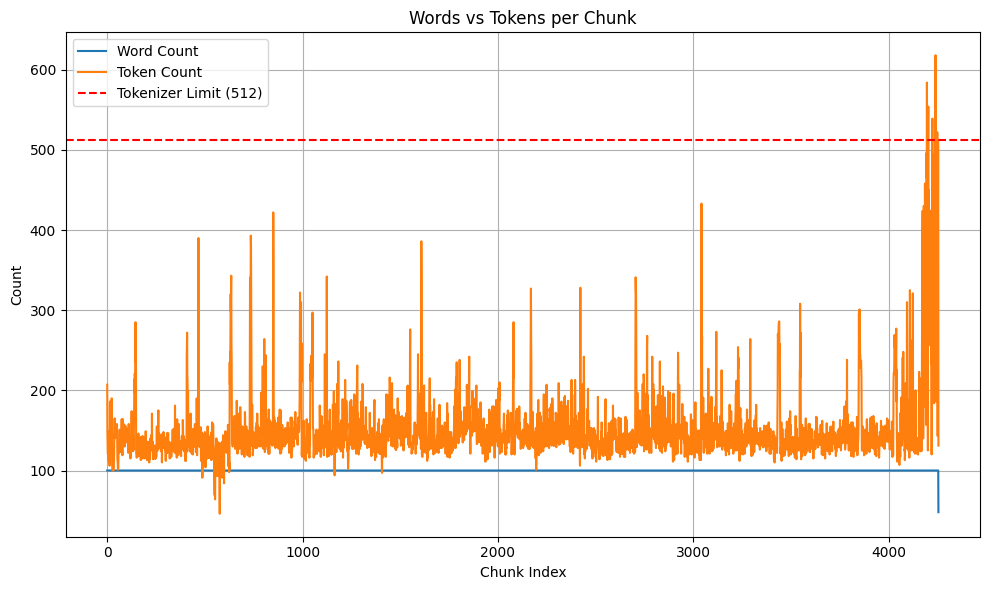

In [4]:
# Load Hugging Face tokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Tokenize and collect metadata (length of words and tokens in each text chunk)
metadata = [{"words": len(c.split()), "tokens": len(tokenizer.encode(c, add_special_tokens=False))} for c in chunks]
df = pd.DataFrame(metadata)

# Compute average words-to-tokens ratio
avg_ratio = (df["words"] / df["tokens"]).mean()
print(f"\n\n\nAverage words-to-tokens ratio: {avg_ratio:.2f}   --> {avg_ratio:.2f} words correspond to 1 token \n\n\n")

# Plot word vs token count
plt.figure(figsize=(10, 6))
plt.plot(df["words"], label="Word Count")
plt.plot(df["tokens"], label="Token Count")
plt.axhline(y=512, color='red', linestyle='--', label='Tokenizer Limit (512)')
plt.xlabel("Chunk Index")
plt.ylabel("Count")
plt.title("Words vs Tokens per Chunk")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

#### 1.4. Filter Overlong Chunks 

In [5]:
def filter_chunks(chunks, tokenizer, max_tokens=512, print_limit=2):
    filtered, printed = [], 0
    for c in chunks:
        tokens = len(tokenizer.encode(c, add_special_tokens=False))
        if tokens < max_tokens:
            filtered.append(c)
        elif printed < print_limit:
            print(f"Discarded chunk (tokens={tokens}):\n{c}\n")
            printed += 1
    return filtered

chunks = filter_chunks(chunks, tokenizer, max_tokens=512, print_limit=2)

Discarded chunk (tokens=584):
sigxp*beam[1,:]+xp0 output_a = transportParticles(beam, 5*fodo_lattice) plt.plot(output_a['s'], np.std(output_a['x'],0)*1e3, 'o-b', lw=3) plt.grid(True) plt.xlabel('s [m]') plt.gca().set_ylabel('std(x) [mm]', color='b') plt.gca().tick_params(axis='y', labelcolor='b') plt.ylim(0,7) ax2 = plt.gca().twinx() # instantiate a second axes that shares the same x-axis ax2.set_ylabel("std(x') [mrad]", color='r') ax2.tick_params(axis='y', labelcolor='r') plt.plot(output['s'], np.std(output['px'],0)*1e3, 's-r', lw=3) plt.ylim([0,3]) plt.title('Exercise 15, case A'); # Case B plt.figure() #prepare the beam Npart = 100000 842 **Page:857** beam = np.random.randn(2, Npart) x0 = 0 xp0 = 1 sigx = 1 sigxp = 0.5/2 beam[0,:] = sigx*beam[0,:]+x0 beam[1,:] = sigxp*beam[1,:]+xp0 output_b = transportParticles(beam, 5*fodo_lattice) plt.plot(output_b['s'], np.std(output_b['x'],0), 'o-b', lw=3) plt.grid(True) plt.xlabel('s [m]') plt.gca().set_ylabel('std(x) [mm]', color='b') plt.gca(

## 2. Create Embeddings of the Database

Embedding is the process of converting text chunks into dense numerical vectors that capture their semantic meaning.

This implementation allows choosing between a local embedding model (SentenceTransformer) or a remote API model for flexibility in deployment.

In [6]:
def embed_text_chunks(chunks, use_local=True, local_model='all-MiniLM-L6-v2',
                      api_url="http://lbllm.cern.ch:7999/v1/embeddings", api_model="/models/e5-large-v2"):
    if use_local:
        model = SentenceTransformer(local_model)
        return model.encode(chunks, convert_to_tensor=False), model
    else:  # Use API
        headers = {"Content-Type": "application/json"}
        payload = json.dumps({"model": api_model, "input": chunks})
        resp = requests.post(api_url, headers=headers, data=payload)
        data = resp.json()
        embs = data.get("embeddings") or [d["embedding"] for d in data.get("data", [])]
        if isinstance(embs[0], list):
            embs = np.array(embs)

        class APIEmbedder:
            def encode(self, texts, convert_to_tensor=False):
                body = json.dumps({"model": api_model, "input": texts})
                r = requests.post(api_url, headers=headers, data=body)
                res = r.json()
                return res.get("embeddings") or [d["embedding"] for d in res.get("data", [])]

        return embs, APIEmbedder()
        
# Local model usage:
local_embeddings, local_embedder = embed_text_chunks(chunks, use_local=True)
print("Local embeddings shape:", np.array(local_embeddings).shape)

# API usage:
api_embeddings, api_embedder = embed_text_chunks(chunks, use_local=False)
print("API embeddings shape:", np.array(api_embeddings).shape)

Local embeddings shape: (4249, 384)
API embeddings shape: (4249, 1024)


## 3. Building the Retriever 

Retrieves context from the database based on text chunk similarity. In RAG, usually, the similarity is calculated by the cosine similarity between the querry and all data base embedding vectors.


Cosine Similarity Formula:
$$
\text{cosine similarity} = \frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\| \times \|\vec{b}\|}
$$
Short Description:

Cosine similarity measures the cosine of the angle between two vectors. It is widely used in text analysis because it focuses on the orientation (or direction) of the vectors rather than their magnitude. This makes it ideal for comparing text embeddings to determine how similar two pieces of text are.

In [7]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def retrieve_relevant_chunks(query, embedder, chunk_embeddings, chunks, top_k=3):
    """
    Retrieve the top_k chunks most similar to the query using cosine similarity.
    """
    query_embedding = embedder.encode([query], convert_to_tensor=False)[0]
    similarities = np.array([cosine_similarity(query_embedding, emb) for emb in np.array(chunk_embeddings)])
    top_indices = similarities.argsort()[-top_k:][::-1]
    retrieved_chunks = [chunks[i] for i in top_indices]
    top_scores = [similarities[i] for i in top_indices]
    return retrieved_chunks, top_scores


# Local model usage:
query = "What is discussed?"
retrieved_chunks_local, scores_local = retrieve_relevant_chunks(query, local_embedder, local_embeddings, chunks, top_k=2)
print("Local retrieved chunks:")
for i, (score, chunk) in enumerate(zip(scores_local, retrieved_chunks_local)):
    print(f"Chunk {i+1}:")
    print(f"Score: {score:.4f}")
    print(chunk)
    print()

# API usage:
retrieved_chunks_api, scores_api = retrieve_relevant_chunks(query, api_embedder, api_embeddings, chunks, top_k=2)
print("\n\nAPI retrieved chunks:")
for i, (score, chunk) in enumerate(zip(scores_api, retrieved_chunks_api)):
    print(f"Chunk {i+1}:")
    print(f"Score: {score:.4f}")
    print(chunk)
    print()


Local retrieved chunks:
Chunk 1:
Score: 0.2810
Space charge We will now see a ﬁrst ”real” collective effect, namely the space charge effect. Here, the beam charge plays a central role. The larger the charge, the larger the effect. This is what makes it, essentially, an actual collective effect. We will ﬁrst discuss the meaning and the impact of direct space charge effects and then move over to describing in more detail the indirect space charge effects. We will also show means of how to mitigate space charge effects. For some of these impacts we will give a more formal description, for others we will stick to

Chunk 2:
Score: 0.2744
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . v Course Poster 2021 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



API retrieved chunks:
Chunk 1:
Score: 0.7659
of Jyväkylä, Finland (CERN yellow report: CERN 94-01). Much effort has been spent in the past two 

### Plot similarity distributions

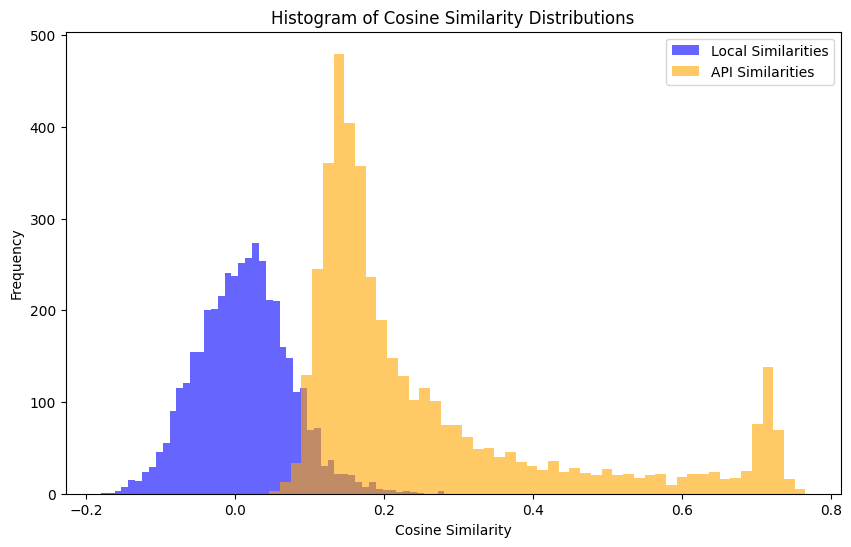

In [8]:
# For local model:
_, local_similarities = retrieve_relevant_chunks(query, local_embedder, local_embeddings, chunks, top_k=5000)

# For API:
_, api_similarities = retrieve_relevant_chunks(query, api_embedder, api_embeddings, chunks, top_k=5000)

# Plot histogram for both distributions
plt.figure(figsize=(10, 6))
bins = 50
plt.hist(local_similarities, bins=bins, alpha=0.6, label="Local Similarities", color="blue")
plt.hist(api_similarities, bins=bins, alpha=0.6, label="API Similarities", color="orange")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Histogram of Cosine Similarity Distributions")
plt.legend()
plt.show()

Observations: 
1) The local model applies normalization, and the API model not.
2) Similarity is a relative metrics which changes model dependent.


Use the API Embedding model in the following 

In [9]:
retrieved_chunks, scores = retrieved_chunks_api, scores_api

## 4. Integrating an LLM for Final Answer Generation

In [10]:
def call_llm(messages, max_tokens=250):
    """
    Calls the API server to generate a chat completion.
    """
    base_url = "http://cs-513-ml003:3000"
    API_key = "AccGPT-API"
    model_name = "llama3-70b-8192"
    
    chat_payload = {
        "messages": messages,
        "max_tokens": max_tokens,
        "model": model_name,
        "temperature": 0.1,
    }
    
    chat_response = requests.post(
        f"{base_url}/chat",
        json=chat_payload,
        headers={"X-API-Key": API_key, "Content-Type": "application/json"}
    )
    chat_response.raise_for_status()
    return chat_response.json()

system_prompt = "You are an expert assistant that answers questions using the provided document context."
retrieved_context = "\n".join(retrieved_chunks)  # retrieved_chunks from your retrieval step

messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": f"{query}\n\nContext:\n{retrieved_context}"}
]

response = call_llm(messages, max_tokens=250)
output = response.get("choices", [{}])[0].get("message", {}).get("content", "No response received.")
print("LLM Response:\n", output)


LLM Response:
 The document discusses the proceedings of an introductory course on accelerator physics, specifically the CERN Accelerator School (CAS) course.


# Wrap-Up and Full Pipeline Demo 

### 1) Data preparation

In [11]:
# Step 1: Extract text from the PDF.
pdf_text = retrieve_pdf_text(pdf_path)

# Step 2: Split the full text into manageable chunks. Filter chunks that exceed token limits.
chunks = split_text_into_chunks(pdf_text, max_chunk_size=100, overlap=10)
chunks = filter_chunks(chunks, tokenizer, max_tokens=512, print_limit=0)

# Step 3: Compute embeddings for each text chunk.
chunk_embeddings, embedder = embed_text_chunks(chunks, use_local=False)


### 2) Retrieval and output generation

In [12]:
def get_llm_output(query, embedder, chunk_embeddings, chunks, top_k=3, show_chunks=False, max_tokens=250):
    """
    Given a query, this function retrieves the most relevant text chunks using cosine similarity,
    builds a prompt with system instructions and the retrieved context,
    and returns the LLM output from the second API server.
    """
    # Step 4: Retrieve the most relevant chunks using cosine similarity.
    retrieved_chunks, scores = retrieve_relevant_chunks(query, embedder, chunk_embeddings, chunks, top_k=top_k)
    
    if show_chunks:
        print("Retrieved Chunks:")
        for idx, (chunk, score) in enumerate(zip(retrieved_chunks, scores)):
            print(f"--- Chunk {idx+1} (Score: {score:.4f}) ---")
            print(chunk)
            print()
        print("\n\n")
    
    # Step 5: Build the prompt with a system instruction and the retrieved context.
    system_prompt = "You are an expert assistant that answers questions using the provided document context."
    retrieved_context = "\n".join(retrieved_chunks)
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"{query}\n\nContext:\n{retrieved_context}"}
    ]
    
    # Step 6: Call the second API server to generate the final answer.
    response = call_llm(messages, max_tokens=max_tokens)
    llm_output = response.get("choices", [{}])[0].get("message", {}).get("content", "No response received.")
    return llm_output

# Example usage:
query = "When was the CERN Accelerator School established?"
llm_output = get_llm_output(query, embedder, chunk_embeddings, chunks, top_k=2, show_chunks=True)
print("LLM Response:\n", llm_output)


Retrieved Chunks:
--- Chunk 1 (Score: 0.8459) ---
Hands-On courses. The individual manuscripts for the present proceedings have been collected from the lecturers after the course. Each manuscript has been published individually as preprint on the arXiv–repository under the name of the author. The present document, the proceedings of the introductory CAS course, are just a compilation of all contributions. The proceedings are available for electronic download on the website of the CERN–Accelerator– School or through the CAS secretariat as printed copy. ii **Page:3** Preface The CERN Accelerator School (CAS) was established in 1983 with the mission to preserve and disseminate the knowledge accumulated at CERN and elsewhere

--- Chunk 2 (Score: 0.8334) ---
the ideal opportunity to be introduced into the field of particle accelerators. This course will be of interest to staff and students from laboratories and universities, as well as companies manufacturing accelerator equipment. The cour

#### Compare response to the LLM output WITHOUT RAG for the same question

In [13]:
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": f"{query}"}
]

response = call_llm(messages, max_tokens=250)
output = response.get("choices", [{}])[0].get("message", {}).get("content", "No response received.")
print("LLM (without RAG) Response:\n", output)

LLM (without RAG) Response:
 The CERN Accelerator School was established in 1985.


#### Another question:

In [14]:
query = "The time for pions at rest to decay by half is?" # page 221
llm_output = get_llm_output(query, embedder, chunk_embeddings, chunks, top_k=10, show_chunks=False)
print("LLM Response:\n", llm_output)

LLM Response:
 The time for pions at rest to decay by half is approximately 1.8 x 10^(-8) seconds.


In [15]:
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": f"{query}"}
]

response = call_llm(messages, max_tokens=250)
output = response.get("choices", [{}])[0].get("message", {}).get("content", "No response received.")
print("LLM (without RAG) Response:\n", output)

LLM (without RAG) Response:
 According to the context, the time for pions at rest to decay by half, also known as the half-life, is 26 nanoseconds.
